In [1]:
from matplotlib import pyplot as plt
import nibabel as nib
import numpy as np
import glob
from tqdm import tqdm
from scipy.ndimage import zoom
from tensorflow.keras import layers, Model

In [2]:
files = glob.glob("../../Data/Pre-processed/*.nii.gz")

cropped_images = []
target_size = (80,96,80)

# Crop the image to only contain the brain
def crop_brain(img, target_size=(140,172,136)):
    brain_mask = img > 0.01
    # Find bounds in all axes
    bounds = np.where(brain_mask)
    x_min, x_max, y_min, y_max, z_min, z_max = np.min(bounds[0]), np.max(bounds[0]), np.min(bounds[1]), np.max(bounds[1]), np.min(bounds[2]), np.max(bounds[2])
    brain_img = img[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]

    # Resize to target dimensions
    zoom_factors = [t / b for t, b in zip(target_size, brain_img.shape)]
    brain_img = zoom(brain_img, zoom_factors, order=1)  # Linear interpolation
    
    return brain_img

for file in tqdm(files[:100],"Loading images"):
    img = nib.load(file).get_fdata()
    cropped_images.append(crop_brain(img, target_size=target_size))

# Normalize image magnitude
for i in tqdm(range(len(cropped_images)),"Normalizing images"):
    q2m = .785700/.475665
    fac = np.min([q2m / np.quantile(cropped_images[i],0.98), 1. / np.max(cropped_images[i])])
    cropped_images[i] = cropped_images[i] * fac
    
cropped_images = np.stack(cropped_images)

Normalizing images: 100%|██████████| 100/100 [00:00<00:00, 272.44it/s]


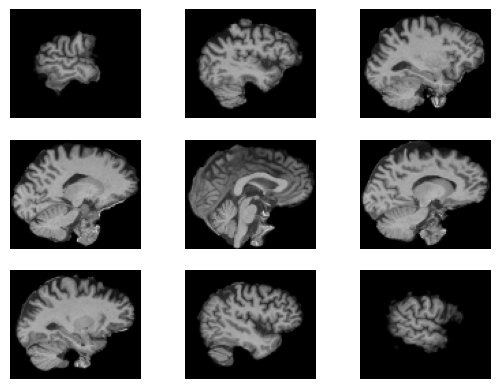

In [8]:
def imdisp(im, slice_axis=0):
    # Display 9 slices
    for i in range(9):
        plt.subplot(3, 3, i+1)
        slice_im = None
        j = int((i+1)*im.shape[slice_axis]/10)
        if slice_axis == 0: slice_im = im[j, :, :]
        if slice_axis == 1: slice_im = im[:, j, :]
        if slice_axis == 2: slice_im = im[:, :, j]
        plt.imshow(np.rot90(slice_im), cmap='gray',vmin=0,vmax=0.9)
        plt.axis('off')
    #plt.subplots_adjust(wspace=-0.55, hspace=0.04)
imdisp(cropped_images[0])

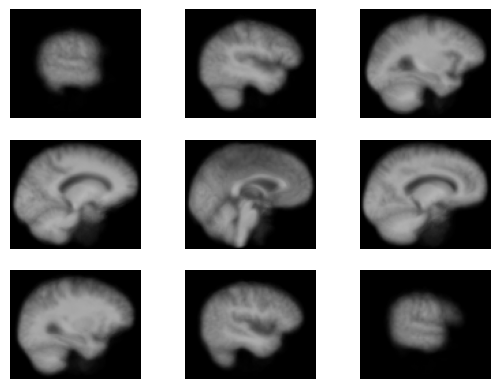

In [9]:
mean_brain = np.mean(cropped_images, axis=0).reshape(target_size)
# inv_std_brain = np.clip(1. / np.std(cropped_images, axis=0),0,20).reshape(target_size)
diffs = cropped_images - mean_brain
# norm_diffs = diffs * inv_std_brain
imdisp(mean_brain)

# Model the brain with an Auto-Encoder

In [40]:
class AutoEncoder3D:
    def __init__(self, input_shape):
        # Encoder
        encoder_input = layers.Input(shape=input_shape)
        x = layers.Conv3D(4, (3, 3, 3), activation="relu", padding="same")(encoder_input)
        x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Single downscale block
        x = layers.Dropout(0.1)(x)
        
        x = layers.Conv3D(4, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Single downscale block
        
        encoded = layers.Conv3D(2, (3, 3, 3), activation="relu", padding="same")(x)  # Latent space

        self.encoder = Model(encoder_input, encoded, name="encoder")

        # Decoder
        decoder_input = layers.Input(shape=encoded.shape[1:])  # Adjusted latent space shape
        x = layers.Conv3D(2, (3, 3, 3), activation="relu", padding="same")(decoder_input)
        x = layers.UpSampling3D((2, 2, 2))(x)  # Single upscale block
        
        x = layers.Conv3D(4, (3, 3, 3), activation="relu", padding="same")(x)
        x = layers.UpSampling3D((2, 2, 2))(x)  # Single upscale block

        # old activation (before looking at diffs to mean brain): sigmoid
        decoded = layers.Conv3D(1, (3, 3, 3), activation="tanh", padding="same")(x)  # Final output layer

        self.decoder = Model(decoder_input, decoded, name="decoder")

        # Full Autoencoder (combine encoder and decoder)
        autoencoder_input = encoder_input
        autoencoder_output = self.decoder(self.encoder(encoder_input))
        self.autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")

        # Compile the autoencoder
        self.autoencoder.compile(loss='mean_squared_error', optimizer='adam')
        self.autoencoder.summary()

    def train(self, x_train, epochs=2, batch_size=16):
        history = self.autoencoder.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2
        )
        return history

    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)

ae = AutoEncoder3D(list(target_size) + [1])

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 80, 96, 80, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 20, 24, 20, 2)  │           766 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 80, 96, 80, 1)  │           439 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,205 (4.71 KB)

 Trainable params: 1,205 (4.71 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
ae.train(diffs, epochs=100,batch_size=64)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 715ms/step - loss: 0.0097 - val_loss: 0.0078
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 494ms/step - loss: 0.0095 - val_loss: 0.0076
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - loss: 0.0094 - val_loss: 0.0074
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - loss: 0.0090 - val_loss: 0.0071
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 512ms/step - loss: 0.0088 - val_loss: 0.0070
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - loss: 0.0083 - val_loss: 0.0068
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 512ms/step - loss: 0.0082 - val_loss: 0.0067
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - loss: 0.0080 - val_loss: 0.0065
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - loss: 0.0076 - val_loss: 0.0064
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 493ms/step - loss: 0.0077 - val_loss: 0.0063
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - loss: 0.0075 - val_loss: 0.0062
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - loss: 0.0

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


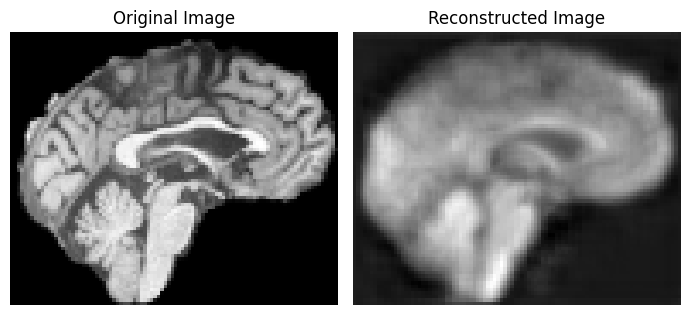

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


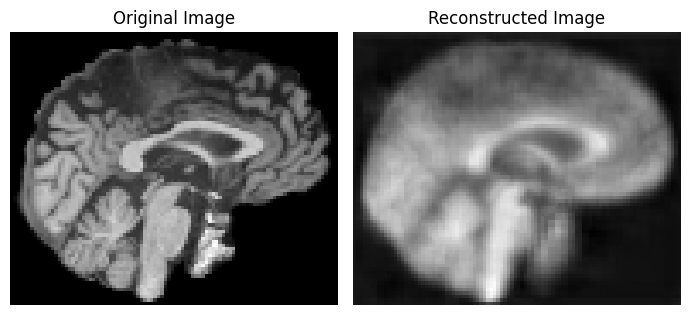

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


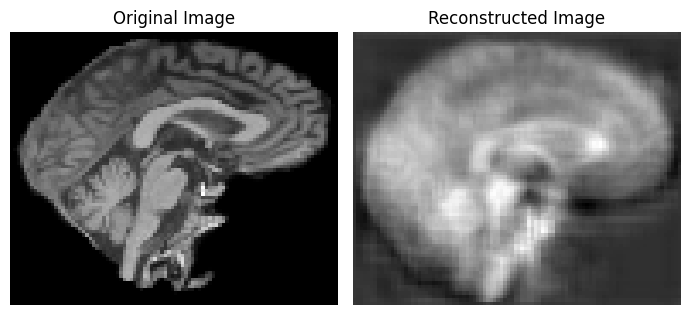

In [45]:
def reconstruct_and_plot(im):
    # im = diffs[im_id]
    # Encode the image and reconstruct
    latent = ae.encode(im[np.newaxis, ...])  # Add batch dimension
    recon = ae.decode(latent)[0]  # Remove batch dimension after decoding
    
    # Set up the plot
    fig, ax = plt.subplots(1, 2, figsize=(7, 4), sharey=True)
    j = im.shape[0] // 2  # Middle slice along depth

    # Plot original image slice
    ax[0].imshow(np.rot90(mean_brain[j]+ im[j].reshape((96,80))), cmap='gray')
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Plot reconstructed image slice
    ax[1].imshow(np.rot90(mean_brain[j]+recon[j].reshape((96,80))), cmap='gray')
    ax[1].set_title("Reconstructed Image")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()
    return recon

recon = reconstruct_and_plot(diffs[3])
recon = reconstruct_and_plot(diffs[10])
recon = reconstruct_and_plot(diffs[1])

In [ ]:
def remove_chunks(img,radius=6):
    radius_sqr = radius**2
    point = np.zeros(3).astype("int16")
    point[1] = img.shape[1]//2
    while img[point[0],point[1],point[2]] < 0.1:
        point = np.random.uniform(np.zeros(3),img.shape).astype("int16")
        point[1] = img.shape[1]//2
    x = np.arange(img.shape[0])
    y = np.arange(img.shape[1])
    z = np.arange(img.shape[2])
    X,Y,Z = np.meshgrid(x,y,z)
    return img * np.where( (X-point[0])**2+(Y-point[1])**2+(Z-point[2])**2 < radius_sqr,0,1).reshape(img.shape)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 


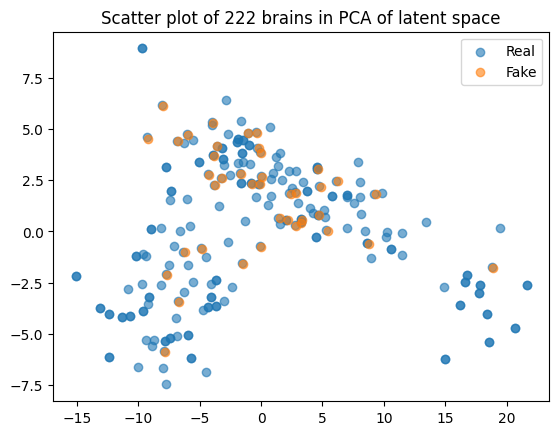

In [ ]:
latent_real = ae.encode(cropped_images)
latent_real = latent_real.reshape(len(latent_real),-1)

latent_fake = ae.encode(np.stack([remove_chunks(img) for img in cropped_images[:40]]))
latent_fake = latent_fake.reshape(len(latent_fake),-1)

from sklearn.decomposition import PCA
pca = PCA(2)
xy = pca.fit_transform(latent_real)

plt.title(f"Scatter plot of {len(xy)} brains in PCA of latent space")
plt.scatter(xy[:,0],xy[:,1],alpha=0.6, label="Real")

xy = pca.transform(latent_fake)
plt.scatter(xy[:,0],xy[:,1],alpha=0.6, label="Fake")

plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


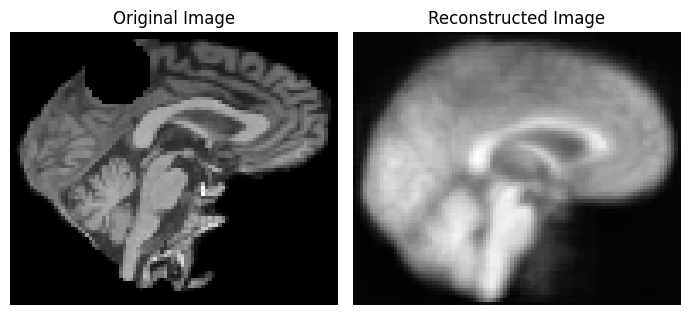

In [ ]:
recon = reconstruct_and_plot(remove_chunks(cropped_images[1],10)-mean_brain)


(80, 96, 61)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


ValueError: cannot reshape array of size 5856 into shape (96,80)

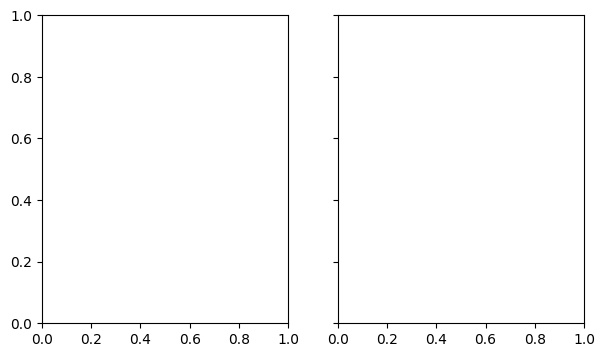

In [36]:
cat_img = np.rot90(plt.imread("../../Data/brain.png")[:,:,1],k=3)
cat_img = np.stack([zoom(cat_img,target_size[1:] / np.array(cat_img.shape[:1]))]*target_size[0])
print(cat_img.shape)
recon = reconstruct_and_plot(cat_img)